## Import Necessary Modules

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, defaultdict
import random
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
    from JSAnimation.IPython_display import display_animation
    print("Ipython")
else:  
    print("pyvd")
    from pyvirtualdisplay import Display
    display = Display(visible=True, size=(1400, 900))
    display.start()
    
_=plt.ion()

import ddpg_agent
from ddpg_agent import Agent, device, BUFFER_SIZE, SEED

print("Using device {} from ddpg_agent".format(device)) 


Ipython
Using device cuda:0 from ddpg_agent


## Instantiate an Agent to Train in the Gym LunarLander Environment

In [2]:
env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
seed=SEED
state_size=env.observation_space.shape[0]
action_size=env.action_space.shape[0]
print(state_size, action_size)


8 2


In [3]:
#agent = ddpg_agent.Agent(state_size=state_size, action_size=action_size, num_agents=1, random_seed=SEED)

agent = Agent(  state_size=state_size, action_size=action_size, random_seed=SEED,
                actor_units_in=256, actor_units_hid=128,
                critic_units_in=512, critic_units_hid=128
             )

## Examine the State and Action Spaces

In [4]:
# reset the environment
state, info = env.reset(seed=SEED)

# number of agents
num_agents = 1 #len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

# examine the state space 
state_size = env.observation_space.shape[0]
print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:\n', state)
print('The action for the first agent looks like:\n', agent.act(state))

Number of agents: 1
Size of each action: 2
There are 1 agents. Each observes a state with length: 8
The state for the first agent looks like:
 [ 0.00580549  1.4191229   0.58801913  0.36455828 -0.00672034 -0.13319503
  0.          0.        ]
The action for the first agent looks like:
 [ 0.4215779  -0.10162636]


In [5]:
#agent = ddpg_agent.Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0, 
#                         actor_filename='checkpoint_actor2.pth', critic_filename='checkpoint_critic2.pth')

## Training Routines

### DQN-style training

In [8]:
def dqn(n_episodes=2000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    FIRST = True
    start = time.time()
    scores = []
    episode_times = []; episode_lengths = [] 
    action_steps = []; noise_steps= []
    actor_loss = []; critic_loss = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        epistart = time.time()
        state, _ = env.reset(seed=SEED)
        score = 0; episteps = 0; a_loss = [] ; c_loss = []
        for t in range(max_t):
            action, noise = agent.act(state, return_noise=True)
            action_steps.append(action)
            noise_steps.append(noise)
            action = np.clip(action+noise, -1, 1)
            next_state, reward, done, trun, _ = env.step(action)
            al, cl = agent.step(state, action, reward, next_state, done or trun, return_loss=True)
            a_loss.append(al); c_loss.append(cl)
            state = next_state; score += reward; episteps += 1
            if done or trun:
                break              
        
        # Data appendage
        scores_window.append(score)       
        scores.append(score)
        episode_lengths.append(episteps)
        actor_loss.append(np.mean(a_loss))          
        critic_loss.append(np.mean(c_loss))
        episode_times.append(time.time()-epistart)
        
        cycle_steps = agent.steps%BUFFER_SIZE
        buffer_cycle = agent.steps//BUFFER_SIZE

        print("\rEpisode {:4d} | Score: {:8.2f} | Actor Loss: {:8.2f} | Critic Loss: {:8.2f} | Episode: {:4d} Steps in {:5.3f} sec | Memory Buffer:{:7d} into cycle {:3d}".format(i_episode, score,
                                                                                                                                                                                np.mean(a_loss), np.mean(c_loss),
                                                                                                                                                                                episteps, time.time()-epistart,
                                                                                                                                                                                cycle_steps, buffer_cycle), end="")
                                                                                                                                        
        if i_episode % 10 == 0:
            chkpntname = "data/actor_chkpnt{}.pth".format(i_episode)
            torch.save(agent.actor_target.state_dict(), chkpntname)  
            chkpntname = "data/critic_chkpnt{}.pth".format(i_episode)
            torch.save(agent.critic_target.state_dict(), chkpntname) 
            print("\rEpisode {:4d} | Score: {:8.2f} | Actor Loss: {:8.2f} | Critic Loss: {:8.2f} | Average: {:5.1f} Steps in {:5.3f} sec | Memory Buffer:{:7d} into cycle {:3d}".format(i_episode, 
                                                                                                                                                                                    np.mean(scores_window), np.mean(a_loss), np.mean(c_loss),
                                                                                                                                                                                    np.mean(episode_lengths), np.mean(episode_times),
                                                                                                                                                                                    cycle_steps, buffer_cycle))
        
        if np.mean(scores_window)>=100. and FIRST:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_target.state_dict(), 'data/actor_slvdpnt.pth')
            torch.save(agent.critic_target.state_dict(), 'data/critic_slvdpnt.pth')
            FIRST = False
        elif np.mean(scores_window)>=150. :
            print("\n***** High Score! *****")
            print("\tGame over.")
            torch.save(agent.actor_target.state_dict(), 'data/actor_hipnt.pth')
            torch.save(agent.critic_target.state_dict(), 'data/critic_hipnt.pth')
            break
            
    t_time = time.time() - start
    print("Total time: {:3d} minutes {:4.2f} seconds \tAvg. Episode time: {:5.3f} seconds \tAvg. Episode steps: {:5.3f}".format(int(t_time//60),
                                                                                                                                   t_time%60,
                                                                                                                                   t_time/i_episode,
                                                                                                                                   agent.steps/i_episode))
    return scores, episode_lengths, episode_times, action_steps, noise_steps, actor_loss, critic_loss

In [7]:
scores, episode_lengths, episode_times, action_steps, noise_steps, actor_loss, critic_loss = dqn(n_episodes=1000, max_t=888)

Episode   10 | Score:  -926.57 | Actor Loss:     5.86 | Critic Loss:    63.17 | Average: 102.5 Steps in 0.827 sec | Memory Buffer:   1025 into cycle   0
Episode   20 | Score:  -801.16 | Actor Loss:     8.28 | Critic Loss:    71.64 | Average:  97.1 Steps in 0.851 sec | Memory Buffer:   1942 into cycle   0
Episode   30 | Score:  -719.24 | Actor Loss:     8.32 | Critic Loss:    71.86 | Average:  97.9 Steps in 0.886 sec | Memory Buffer:   2936 into cycle   0
Episode   40 | Score:  -749.37 | Actor Loss:     3.68 | Critic Loss:    74.81 | Average:  96.3 Steps in 0.890 sec | Memory Buffer:   3853 into cycle   0
Episode   50 | Score:  -766.19 | Actor Loss:  -781.78 | Critic Loss:   382.10 | Average:  93.2 Steps in 0.869 sec | Memory Buffer:   4659 into cycle   0
Episode   60 | Score:  -787.78 | Actor Loss: -78864.28 | Critic Loss: 7040942.81 | Average:  92.1 Steps in 0.865 sec | Memory Buffer:   5528 into cycle   0  0
Episode   70 | Score:  -799.95 | Actor Loss: -973606.01 | Critic Loss: 14388

### DDPG-style training

In [ ]:
### DDPG routine from Solution Notebook ####

def ddpg(n_episodes=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    agent_scores = []
    for i_episode in (range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = 0.
        individual_scores = np.zeros(num_agents)
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += np.mean(reward)
            individual_scores += reward
            if np.any(done):
                break 
        scores_deque.append(score)
        scores.append(score)
        agent_scores.append(individual_scores)
        print('\rEpisode {}\tReward: {:.2f}\tAverage Reward: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        
        if i_episode % 5 == 0:
            print('\rEpisode {}\tReward: {:.2f}\tAverage Reward: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        
        if sum(np.array(scores_deque)>=30)>=100:
            print('\n\nEnvironment Solved in {:d} episodes!\tAverage Reward: {:.2f}'.format(i_episode-100,
                                                                                          np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores, agent_scores




In [ ]:
#scores, agent_scores = ddpg()

When finished, close the environment.

In [ ]:
env.close()

# Evaluation

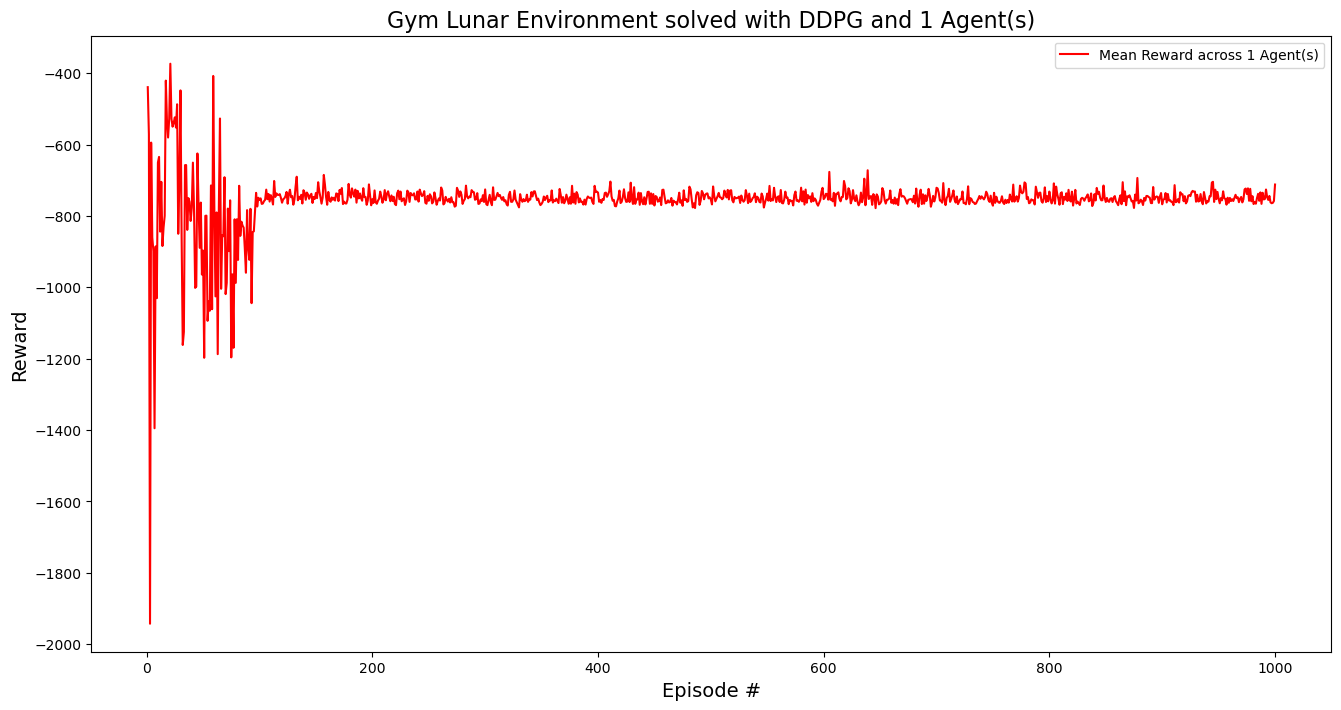

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(np.arange(1, len(scores)+1), scores, color='r', label='Mean Reward across 1 Agent(s)')
#for i in range(20):
#    ax.plot(np.arange(1, len(scores)+1), [s[i] for s in agent_scores], alpha=0.1)
plt.legend()
ax.set_xlabel('Episode #', fontsize=14)
ax.set_ylabel('Reward', fontsize=14)
ax.set_title('Gym Lunar Environment solved with DDPG and 1 Agent(s)', fontsize=16)
plt.show()

## Random Runs

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)       # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False) # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [ ]:
env.close()

## More Plots, More Data

In [ ]:
states, actions, rewards, next_states, dones = zip(*agent.memory.memory)

In [ ]:
memsam = agent.memory.sample(), len(agent.memory)

#[(r, a[0], a[1]) for r,a in zip(norm(rewards[100:-100]), actions[100:-100]) if a[0]!=1 and (a[1]>=0.5 or a[1]<=-0.5)]
#np.mean([r for r,a in zip(rewards,actions) if a[0]>=0.5]), np.mean(rewards)
#sum(actions[0])

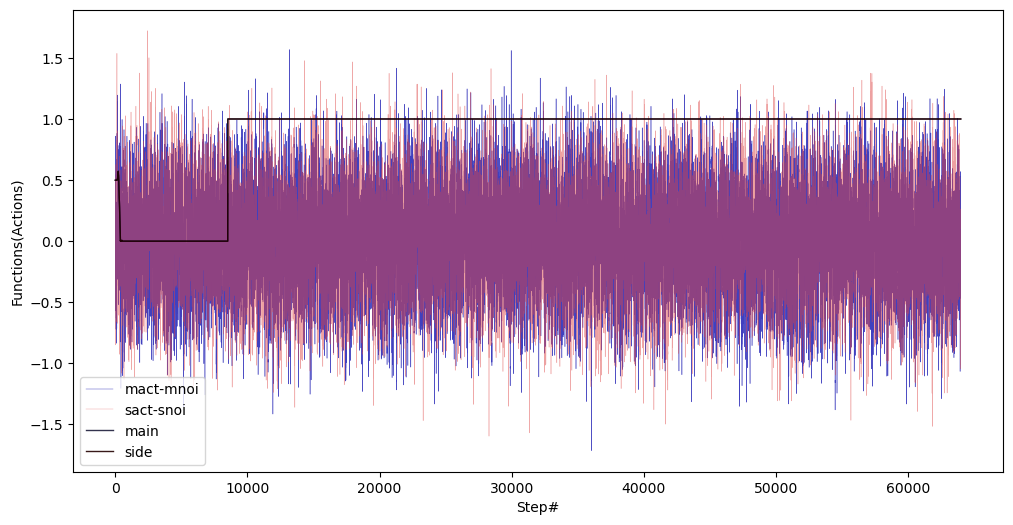

In [17]:
### Action / Noise plot

### action_noise array shape(50000, (a0,a1), (n0,n1))
#action_noise[-10:,0,:] + action_noise[-10:,1,:], len(actions), len(action_noise)

if False: #True:
    mact= [a[0] for a in action_steps]
    mnoi= [n[0] for n in noise_steps]
    sact= [a[1] for a in action_steps]
    snoi= [n[1] for n in noise_steps]
    dim0= len(mact) #action_noise.shape[0]
    x= np.arange(1, dim0+1)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    plt.plot(x, mact, linewidth=0.25, markersize=0.6,alpha=0.6,c='#a00')#
    plt.plot(x, sact, linewidth=0.25, markersize=0.6,alpha=0.6,c='#005')
    ax.legend(["Main Action", "Side Action"])#, "Main Noise","Side Noise"])
    plt.ylabel('Action & Noise values')
    plt.xlabel('Step #')

    lim = dim0 #len(mact)
    xlims = (0,lim)
    ylims = (round(min( min(mact[:lim]), min(sact[:lim]) )),
                round(max( max(mact[:lim]), max(sact[:lim]) )))
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.show()

else:
    m_power = lambda m: (np.clip(m, 0.0, 1.0) + 1.0) * 0.5
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    tanh = lambda x: np.tanh(x)

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    mact= [a[0]+n[0] for a, n in zip(action_steps, noise_steps)]
    mnoi= [n[0] for n in noise_steps]
    sact= [a[1]+n[1] for a, n in zip(action_steps, noise_steps)]
    snoi= [n[1] for n in noise_steps]
    dim1= len(action_steps)#.shape[0]
    x= np.arange(1, dim1+1)
    plt.plot(x, mnoi, linewidth=0.33, markersize=0.33, alpha=0.75, c='#00a')#
    plt.plot(x, snoi, linewidth=0.33, markersize=0.33, alpha=0.5, c='#d44')
    plt.plot(x, [ass[0] for ass in action_steps], linewidth=1.0, markersize=0.33, alpha=0.8, c='#002')
    plt.plot(x, [ass[0] for ass in action_steps], linewidth=1.0, markersize=0.33, alpha=0.9, c='#200')
    ax.legend(["mact-mnoi","sact-snoi","main", "side"])
    plt.ylabel('Functions(Actions)')
    plt.xlabel('Step#')
    plt.show()

NameError: name 'rewards' is not defined

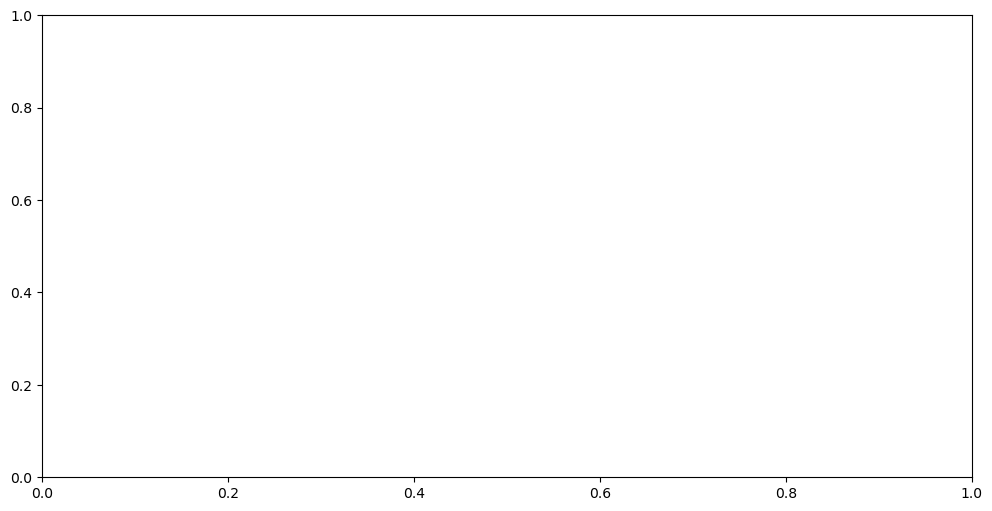

In [18]:
###  plot LOSS
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), norm(rewards), 
         'b,', linewidth=0.1, markersize=0.25,)
lim = len(rewards)+1
xlims = (0,lim)#2000)
ylims = (round(min(norm(rewards)[:lim])), round(max(norm(rewards[:lim]))))
#plt.xlim(*xlims)
#plt.ylim(*ylims)
plt.ylabel('Step rewards normed')
plt.xlabel('Step #')
plt.show()

# Observe Agent Gameplay

In the next code cell, you will load the trained weights from file to watch a smart agent!

Total episode reward:  -755.348


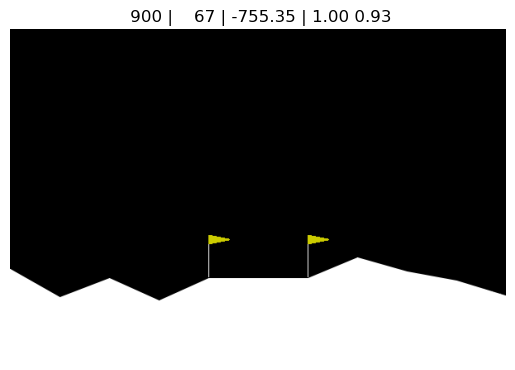

In [20]:
#### "Display" from the DQN notebook
# >> 'watch a pre-trained agent'

for chkpnt in [100,300,900]:
#range(100,1000,300):
#for agent in enumerate(agents):    
    chkpnt_name = "data/actor_chkpnt{}.pth".format(chkpnt)
    agent.actor_local.load_state_dict(torch.load(chkpnt_name))
    chkpnt_name = "data/critic_chkpnt{}.pth".format(chkpnt)
    agent.critic_local.load_state_dict(torch.load(chkpnt_name))
    score = 0
    state, _ = env.reset()
    img = plt.imshow(env.render())
    for j in range(1000):
        action = agent.act(state)
        state, reward, done, trun, _ = env.step(action)
        score += reward
        img.set_data(env.render()) 
        plt.axis('off')
        title = "{:4d} | {:5d} | {:7.2f} | {:2.2f} {:2.2f}".format(chkpnt, j+1, score, action[0], action[1])
        plt.title(title)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done or trun:
            break 
print("Total episode reward: ", np.round(np.sum(score),3))

In [ ]:
state, _ = env.reset()
img=env.render()
plt.imshow(img)

In [ ]:
#### Get data
rewards = []
final_rewards = []
steps = []
actions = []
tries = 100
max_t = 400
for i in range(tries):
    step_count = 0
    reward_sum = 0
    state, info = env.reset(seed=SEED)
    for j in range(max_t):
        action = agent.act(state)
        actions += [action]
        state, reward, done, trun, info = env.step(action)
        if done or trun:
            final_rewards += [reward]
            break 
        else:
            final_rewards += [0]
            reward_sum += reward
            step_count += 1
    steps += [step_count]
    rewards += [reward_sum]
actions = np.asarray(actions)
data = np.asarray([(int(s),r),int(f)) for s,r,f in zip(steps, np.round(rewards,3), final_rewards)])

In [ ]:
### Observe agent gameplay
pix_norm = lambda x: x/255.
SEED=1234
t = 500
smax = nn.Softmax(dim=1)

state, _ = env.reset(seed=SEED)
frame = env.render()
img = plt.imshow(pix_norm(frame))
action =  [random.random(), 2*random.random()-1]
for _ in range(t):
    state1, reward1, is_done, is_trunc, info = env.step(action)
    frame1 =  pix_norm(env.render())
    state2, reward2, is_done, is_trunc, info = env.step((0,0))
    frame2 =  pix_norm(env.render())
    states = np.asarray([scale_input(state1),
                         scale_input(state2)])
    action = [np.round(a,3) for a in agent.act(state2)]
    
    #pols = smax(sigs).detach().cpu().numpy()
    #probs = probs.detach().cpu().numpy()
    #action = np.argmax(probs[-1])
    #reward = reward2 + reward1
    
    frame = scale(frame2-frame1/2)
    img.set_data(frame)
    plt.title("M:"+str(action[0])+" S:"+str(action[1])+" R:"+str(np.round(reward1, 3)))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if is_done or is_trunc:
        break 